## Fetch data

Get the data from the shared Drive folder we have

**This should be improved** by storing the file somewhere smarter

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#https://drive.google.com/open?id=1axFOiWZPTm-ncltlFUWZIptLoTNdtlYg
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1axFOiWZPTm-ncltlFUWZIptLoTNdtlYg'
downloaded = drive.CreateFile({'id': file_id})
print('Downloaded content with length "{}"'.format(len(downloaded.GetContentString())))

# try to load the json data
import json

jsonObject = json.loads(downloaded.GetContentString())

print(type(jsonObject))
print(len(jsonObject))
print(jsonObject[0])

     |████████████████████████████████| 993kB 4.9MB/s 
Downloaded content with length "669380879"
<class 'list'>
573371
{'id': 'http://arxiv.org/abs/1904.03835v4', 'category': 'Physics', 'subject': 'astro-ph.CO', 'title': 'Kaon oscillations and baryon asymmetry of the universe', 'abstract': 'Baryon asymmetry of the universe (BAU) is naturally explained with\n$K^0-K^{0\'}$ oscillations of a newly developed mirror-matter model and new\nunderstanding of quantum chromodynamics (QCD) phase transitions. A consistent\npicture for the origin of both BAU and dark matter is presented with the aid of\n$n-n\'$ oscillations of the new model. The global symmetry breaking transitions\nin QCD are proposed to be staged depending on condensation temperatures of\nstrange, charm, bottom, and top quarks in the early universe. The long-standing\nBAU puzzle can then be understood with $K^0-K^{0\'}$ oscillations that occur at\nthe stage of strange quark condensation and baryon number violation via a\nnon-pert

## Parse the JSON

Physics : 206635
Computer Science : 143555
Economics : 672
Electrical Engineering and Systems Science : 6325
Mathematics : 156471
Quantitative Biology : 25791
Quantitative Finance : 11826
Statistics : 22096
[0.3603862071852256, 0.2503701791684616, 0.001172016024528621, 0.011031252016582631, 0.2728966062113361, 0.04498134715568105, 0.020625389145945645, 0.03853700309223871]


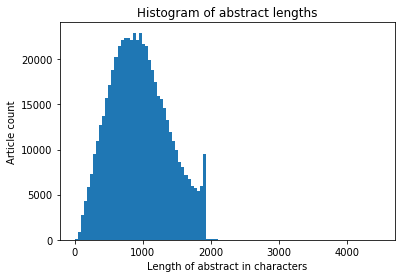

In [0]:
all_categories = []
articles_dict = dict()
for article in jsonObject:
    category = article["category"]
    if category not in all_categories:
        all_categories.append(category)
        articles_dict[category] = []
    articles_dict[category].append(article)
    
n_categories = len(articles_dict.keys())

weights_all_categories = []
for category in all_categories:
    print("{} : {}".format(category, len(articles_dict[category])))
    weights_all_categories.append(len(articles_dict[category])/len(jsonObject))
print(weights_all_categories)

import matplotlib.pyplot as plt

lengths = list(map(lambda a: len(a["abstract"]), jsonObject))
n_bins = 100
plt.hist(lengths, bins=n_bins)
plt.title("Histogram of abstract lengths")
plt.xlabel("Length of abstract in characters")
_ = plt.ylabel("Article count")

## Turn abstracts into tensors

In [0]:
import torch
import string
import unicodedata

n_letters = len(string.printable)+1

def lineToTensor(text):
    tensor = torch.zeros(len(text), 1, n_letters)
    # this is splitting letters with accents into letter + accent
    normalized = unicodedata.normalize("NFD", text)
    for idx, char in enumerate(normalized):
        if unicodedata.category(char) == "Mn":
            continue
        # characters not in string.printable get a "pos" of -1,
        # which goes into the "trash" coordinate
        pos = string.printable.find(char)
        tensor[idx, 0, pos] = 1
    return tensor

print(lineToTensor("Ro"))

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])


## Create the architecture

In [0]:
import torch.nn as nn

n_hidden = n_letters

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()

        self.hidden_size = hidden_size
        
        self.lstm_layer = nn.LSTM(input_size, hidden_size, 1)
        
        
        self.lstm_to_classification = nn.Linear(hidden_size, output_size)

    def forward(self, input):
        hidden , (h_t, c_t) = self.lstm_layer(input)
        output = self.lstm_to_classification(hidden[-1])
        return output
      
rnn=LSTM(n_letters, n_hidden, n_categories)

inp = lineToTensor("Rodrigo is my name")
output = rnn(inp)
print(output)

tensor([[ 0.0500, -0.0585, -0.0110, -0.0643,  0.0362,  0.0395, -0.0222,  0.0001]],
       grad_fn=<AddmmBackward>)


## Prepare for training

In [0]:
def categoryFromOutput(out):
    top_n, top_i = out.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(rnn(lineToTensor("some random line here"))))

from random import choice, choices
import torch
import string

def randomTrainingExample(use_first_n_characters=-1):
    category = choice(all_categories)
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    article = choice(articles_dict[category])
    abstract = article["abstract"][:use_first_n_characters]
    abstract_tensor = lineToTensor(abstract)
    return category, abstract, category_tensor, abstract_tensor
  
def randomWeightedTrainingExample(use_first_n_characters=-1):
    # use the random.choices function with the weights computed earlier
    category = choices(all_categories, weights = weights_all_categories, k = 1)[0]
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    article = choice(articles_dict[category])
    abstract = article["abstract"][:use_first_n_characters]
    abstract_tensor = lineToTensor(abstract)
    return category, abstract, category_tensor, abstract_tensor
    return category

randomWeightedTrainingExample()

import matplotlib.pyplot as plt
def plot_losses(all_losses):
    plt.figure()
    plt.plot(all_losses)

('Computer Science', 1)


## Experiment 1

 - First 50 characters
 - Learning rate $10^{-3}$
 - Non-trivial batch-size $12$
 - All categories, non-weighted

In [0]:
import time
import torch.optim as optim

learning_rate = 0.001
rnn=LSTM(n_letters, n_hidden, n_categories)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(rnn.parameters(), lr = learning_rate, momentum = 0.9)

n_iters = 8000
batch_size = 12
use_first_characters = 50
print_every = 100
plot_every = 50

# keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = s//60
    s -= m*60
    return "{}m {}s".format(m, s)

start = time.time()

for it in range(1, n_iters+1):
  
    optimizer.zero_grad()
    
    training_batch = torch.zeros(use_first_characters, batch_size, n_letters)
    category_batch = torch.zeros(batch_size, dtype=torch.long)
    batch = 0
    while batch < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomTrainingExample(use_first_characters)
        if len(abstract) < use_first_characters:
            # do this nasty "trick" to guarantee all the tensors have the same size
            continue
        
        training_batch[:, batch, :] = abstract_tensor[:, 0, :]
        category_batch[batch] = category_tensor[:]
        batch += 1
        
    output = rnn(training_batch)

    loss = criterion(output, category_batch)
    loss.backward()

    current_loss += loss.item()
    optimizer.step()
      
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0

100 1.25% (0.0m 3.6216280460357666s) 2.08 / Quantitative Biology X Quantitative Finance
200 2.5% (0.0m 7.038017988204956s) 2.079 / Quantitative Biology X Quantitative Finance
300 3.75% (0.0m 10.444596767425537s) 2.066 / Electrical Engineering and Systems Science X Quantitative Finance
400 5.0% (0.0m 13.890560388565063s) 2.091 / Electrical Engineering and Systems Science X Quantitative Biology
500 6.25% (0.0m 17.306110382080078s) 2.097 / Statistics X Computer Science
600 7.5% (0.0m 20.724172830581665s) 2.081 / Electrical Engineering and Systems Science V
700 8.75% (0.0m 24.16887903213501s) 2.076 / Electrical Engineering and Systems Science X Physics
800 10.0% (0.0m 27.592551708221436s) 2.067 / Economics V
900 11.25% (0.0m 30.98652744293213s) 2.079 / Economics V
1000 12.5% (0.0m 34.41636681556702s) 2.063 / Economics X Quantitative Biology
1100 13.75% (0.0m 37.844714641571045s) 2.084 / Physics X Computer Science
1200 15.0% (0.0m 41.29856991767883s) 2.085 / Physics X Quantitative Biology
1

NameError: ignored

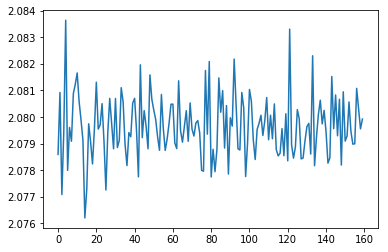

In [0]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(all_losses)

## Experiment 2

 - First 50 characters
 - Learning rate $10^{-2}$
 - Non-trivial batch-size $12$
 - All categories, non-weighted

100 1.25% (0.0m 3.4296159744262695s) 2.097 / Electrical Engineering and Systems Science X Computer Science
200 2.5% (0.0m 6.889303207397461s) 2.087 / Mathematics V
300 3.75% (0.0m 10.322815418243408s) 2.082 / Electrical Engineering and Systems Science X Quantitative Finance
400 5.0% (0.0m 13.78340458869934s) 2.082 / Physics X Quantitative Finance
500 6.25% (0.0m 17.23888850212097s) 2.081 / Electrical Engineering and Systems Science X Statistics
600 7.5% (0.0m 20.671762466430664s) 2.081 / Economics X Statistics
700 8.75% (0.0m 24.098334074020386s) 2.089 / Economics X Electrical Engineering and Systems Science
800 10.0% (0.0m 27.50714349746704s) 2.072 / Mathematics X Economics
900 11.25% (0.0m 30.927239894866943s) 2.083 / Statistics X Economics
1000 12.5% (0.0m 34.37293744087219s) 2.043 / Electrical Engineering and Systems Science V
1100 13.75% (0.0m 37.82812762260437s) 2.102 / Mathematics X Quantitative Biology
1200 15.0% (0.0m 41.27418112754822s) 2.067 / Computer Science X Mathematics


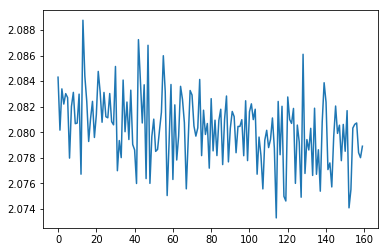

In [0]:
import time
import torch.optim as optim

learning_rate = 0.01
rnn=LSTM(n_letters, n_hidden, n_categories)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(rnn.parameters(), lr = learning_rate, momentum = 0.9)

n_iters = 8000
batch_size = 12
use_first_characters = 50
print_every = 100
plot_every = 50

# keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = s//60
    s -= m*60
    return "{}m {}s".format(m, s)

start = time.time()

for it in range(1, n_iters+1):
  
    optimizer.zero_grad()
    
    training_batch = torch.zeros(use_first_characters, batch_size, n_letters)
    category_batch = torch.zeros(batch_size, dtype=torch.long)
    batch = 0
    while batch < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomTrainingExample(use_first_characters)
        if len(abstract) < use_first_characters:
            # do this nasty "trick" to guarantee all the tensors have the same size
            continue
        
        training_batch[:, batch, :] = abstract_tensor[:, 0, :]
        category_batch[batch] = category_tensor[:]
        batch += 1
        
    output = rnn(training_batch)

    loss = criterion(output, category_batch)
    loss.backward()

    current_loss += loss.item()
    optimizer.step()
      
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

This looks like it just learned something so I'll have it run for longer; also sample the loss for plotting less often, to make it a smoother plot (hopefully)

100 0.2% (0.0m 3.593421220779419s) 2.064 / Economics X Computer Science
200 0.4% (0.0m 7.259978532791138s) 2.091 / Mathematics X Electrical Engineering and Systems Science
300 0.6% (0.0m 10.891610622406006s) 2.052 / Computer Science X Mathematics
400 0.8% (0.0m 14.352420806884766s) 2.111 / Economics X Electrical Engineering and Systems Science
500 1.0% (0.0m 17.809449434280396s) 2.094 / Computer Science X Quantitative Biology
600 1.2% (0.0m 21.3025541305542s) 2.075 / Computer Science X Quantitative Biology
700 1.4% (0.0m 24.741735458374023s) 2.063 / Quantitative Biology X Quantitative Finance
800 1.6% (0.0m 28.1617910861969s) 2.08 / Mathematics X Quantitative Finance
900 1.8% (0.0m 31.619905710220337s) 2.092 / Computer Science X Statistics
1000 2.0% (0.0m 35.06718468666077s) 2.093 / Computer Science X Electrical Engineering and Systems Science
1100 2.2% (0.0m 38.521724224090576s) 2.089 / Mathematics X Electrical Engineering and Systems Science
1200 2.4% (0.0m 41.96983623504639s) 2.051 

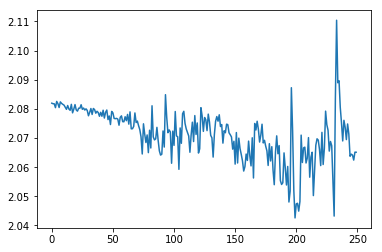

In [0]:
import time
import torch.optim as optim

learning_rate = 0.01
rnn=LSTM(n_letters, n_hidden, n_categories)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(rnn.parameters(), lr = learning_rate, momentum = 0.9)

n_iters = 50000
batch_size = 12
use_first_characters = 50
print_every = 100
plot_every = 200

# keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = s//60
    s -= m*60
    return "{}m {}s".format(m, s)

start = time.time()

for it in range(1, n_iters+1):
  
    optimizer.zero_grad()
    
    training_batch = torch.zeros(use_first_characters, batch_size, n_letters)
    category_batch = torch.zeros(batch_size, dtype=torch.long)
    batch = 0
    while batch < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomTrainingExample(use_first_characters)
        if len(abstract) < use_first_characters:
            # do this nasty "trick" to guarantee all the tensors have the same size
            continue
        
        training_batch[:, batch, :] = abstract_tensor[:, 0, :]
        category_batch[batch] = category_tensor[:]
        batch += 1
        
    output = rnn(training_batch)

    loss = criterion(output, category_batch)
    loss.backward()

    current_loss += loss.item()
    optimizer.step()
      
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

0


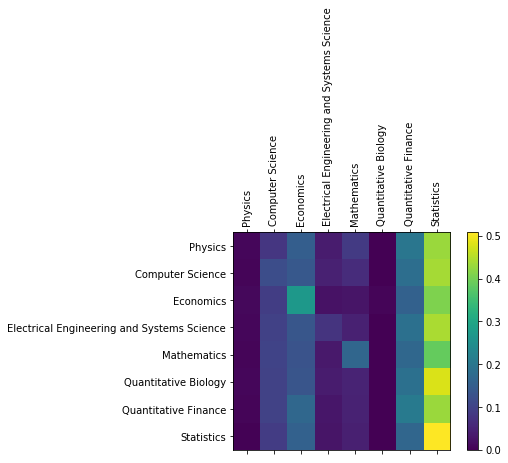

In [0]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    if 0 == i%n_confusion:
        print(i)
    category, line, category_tensor, line_tensor = randomTrainingExample(use_first_characters)
    output = rnn(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

import matplotlib.ticker as ticker
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

## Experiment REAL vs FAKE

 - Real abstracts vs fake abstracts
 - First 50 characters
 - Learning rate $10^{-3}$
 - Non-trivial batch size

100 1.0% (0.0m 3.4555485248565674s) 1.72 / fake X real
200 2.0% (0.0m 6.902029991149902s) 1.366 / fake X real
300 3.0% (0.0m 10.364766597747803s) 1.094 / real X fake
400 4.0% (0.0m 13.828417778015137s) 0.9165 / fake X real
500 5.0% (0.0m 17.29603099822998s) 0.8513 / fake X real
600 6.0% (0.0m 20.77192211151123s) 0.7799 / real X fake
700 7.0% (0.0m 24.240906476974487s) 0.7456 / real V
800 8.0% (0.0m 27.694913625717163s) 0.7301 / real X fake
900 9.0% (0.0m 31.18151354789734s) 0.7181 / fake V
1000 10.0% (0.0m 34.64928889274597s) 0.7092 / fake X real
1100 11.0% (0.0m 38.11556529998779s) 0.7175 / fake X real
1200 12.0% (0.0m 41.588895082473755s) 0.7002 / fake X real
1300 13.0% (0.0m 45.06631016731262s) 0.6971 / real V
1400 14.0% (0.0m 48.66612911224365s) 0.694 / fake V
1500 15.0% (0.0m 52.26449179649353s) 0.6935 / real X fake
1600 16.0% (0.0m 55.726107597351074s) 0.6815 / fake X real
1700 17.0% (0.0m 59.200549840927124s) 0.6678 / fake V
1800 18.0% (1.0m 2.64817476272583s) 0.6722 / real V
19

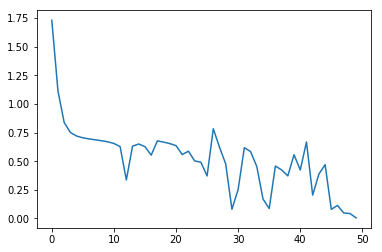

In [0]:
import time
import torch.optim as optim

learning_rate = 0.001
rnn=LSTM(n_letters, n_hidden, n_categories)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(rnn.parameters(), lr = learning_rate, momentum = 0.9)

n_iters = 10000
batch_size = 12
use_first_characters = 50
print_every = 100
plot_every = 200

# keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = s//60
    s -= m*60
    return "{}m {}s".format(m, s)
  
def fakeRealFromOutput(out):
    top_n, top_i = out.topk(1)
    category_i = top_i[0].item()
    cats = ["fake", "real"]
    return cats[category_i], category_i

  
import random
def randomFakeReal(use_first_characters):
    if random.random() < 0.5:
        category = "fake"
        abstract = "".join(choices(string.printable, k=use_first_characters))
        cat_tensor = torch.tensor([0], dtype=torch.long)
    else:
        category = "real"
        article = random.choice(jsonObject)
        abstract = article["abstract"][:use_first_characters]
        cat_tensor = torch.tensor([1], dtype=torch.long)
    return category, abstract, cat_tensor, lineToTensor(abstract)

start = time.time()

for it in range(1, n_iters+1):
  
    optimizer.zero_grad()
    
    training_batch = torch.zeros(use_first_characters, batch_size, n_letters)
    category_batch = torch.zeros(batch_size, dtype=torch.long)
    batch = 0
    while batch < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomFakeReal(use_first_characters)
        if len(abstract) < use_first_characters:
            # do this nasty "trick" to guarantee all the tensors have the same size
            continue
        
        training_batch[:, batch, :] = abstract_tensor[:, 0, :]
        category_batch[batch] = category_tensor[:]
        batch += 1
        
    output = rnn(training_batch)

    loss = criterion(output, category_batch)
    loss.backward()

    current_loss += loss.item()
    optimizer.step()
      
    
    if not (it % print_every):
        guess, guess_i = fakeRealFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

0


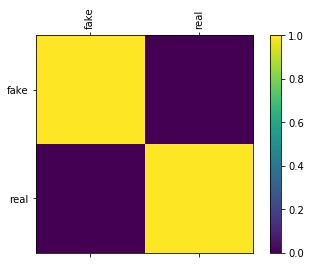

In [0]:
confusion = torch.zeros(2,2)
n_confusion = 10000
cats = ["fake", "real"]

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    if 0 == i%n_confusion:
        print(i)
    category, line, category_tensor, line_tensor = randomFakeReal(use_first_characters)
    output = rnn(line_tensor)
    guess, guess_i = fakeRealFromOutput(output)
    category_i = cats.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(2):
    confusion[i] = confusion[i] / confusion[i].sum()

import matplotlib.ticker as ticker
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + cats, rotation=90)
ax.set_yticklabels([''] + cats)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

## Experiment Maths VS Physics

100 1.0% (0.0m 3.5670852661132812s) 0.7053 / Physics X Mathematics
200 2.0% (0.0m 7.098060369491577s) 0.6813 / Physics V
300 3.0% (0.0m 10.65997314453125s) 0.6879 / Physics X Mathematics
400 4.0% (0.0m 14.21004033088684s) 0.6979 / Mathematics V
500 5.0% (0.0m 17.74361777305603s) 0.6982 / Physics X Mathematics
600 6.0% (0.0m 21.28763198852539s) 0.6935 / Physics V
700 7.0% (0.0m 24.812284231185913s) 0.6949 / Physics V
800 8.0% (0.0m 28.33235216140747s) 0.6935 / Physics V
900 9.0% (0.0m 31.84969162940979s) 0.6938 / Physics X Mathematics
1000 10.0% (0.0m 35.36449074745178s) 0.6969 / Physics X Mathematics
1100 11.0% (0.0m 38.85305452346802s) 0.6894 / Mathematics X Physics
1200 12.0% (0.0m 42.378782749176025s) 0.6937 / Physics V
1300 13.0% (0.0m 45.88483548164368s) 0.6926 / Physics X Mathematics
1400 14.0% (0.0m 49.38077211380005s) 0.6879 / Mathematics V
1500 15.0% (0.0m 52.90553545951843s) 0.6974 / Mathematics X Physics
1600 16.0% (0.0m 56.40938711166382s) 0.6844 / Physics V
1700 17.0% (0.0

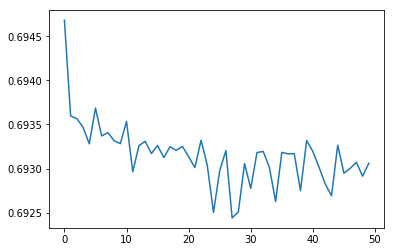

In [0]:
import time
import torch.optim as optim

learning_rate = 0.001
rnn=LSTM(n_letters, n_hidden, 2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(rnn.parameters(), lr = learning_rate, momentum = 0.9)

n_iters = 10000
batch_size = 12
use_first_characters = 50
print_every = 100
plot_every = 200

# keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = s//60
    s -= m*60
    return "{}m {}s".format(m, s)
  
def mathsPhysicsFromOutput(out):
    top_n, top_i = out.topk(1)
    category_i = top_i[0].item()
    cats = ["Mathematics", "Physics"]
    return cats[category_i], category_i

def randomMathsPhysics(use_first_n_characters):
    cats = ["Mathematics", "Physics"]
    category = choice(cats)
    category_tensor = torch.tensor([cats.index(category)], dtype=torch.long)
    article = choice(articles_dict[category])
    abstract = article["abstract"][:use_first_n_characters]
    abstract_tensor = lineToTensor(abstract)
    return category, abstract, category_tensor, abstract_tensor

start = time.time()

for it in range(1, n_iters+1):
  
    optimizer.zero_grad()
    
    training_batch = torch.zeros(use_first_characters, batch_size, n_letters)
    category_batch = torch.zeros(batch_size, dtype=torch.long)
    batch = 0
    while batch < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomMathsPhysics(use_first_characters)
        if len(abstract) < use_first_characters:
            # do this nasty "trick" to guarantee all the tensors have the same size
            continue
        
        training_batch[:, batch, :] = abstract_tensor[:, 0, :]
        category_batch[batch] = category_tensor[:]
        batch += 1
        
    output = rnn(training_batch)

    loss = criterion(output, category_batch)
    loss.backward()

    current_loss += loss.item()
    optimizer.step()
      
    
    if not (it % print_every):
        guess, guess_i = mathsPhysicsFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

0


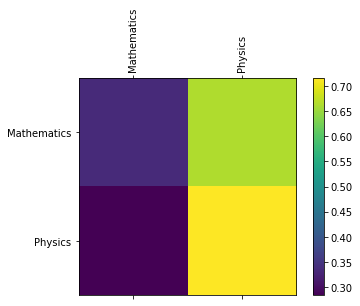

In [0]:
confusion = torch.zeros(2,2)
n_confusion = 10000
cats = ["Mathematics", "Physics"]

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    if 0 == i%n_confusion:
        print(i)
    category, line, category_tensor, line_tensor = randomMathsPhysics(use_first_characters)
    output = rnn(line_tensor)
    guess, guess_i = mathsPhysicsFromOutput(output)
    category_i = cats.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(2):
    confusion[i] = confusion[i] / confusion[i].sum()

import matplotlib.ticker as ticker
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + cats, rotation=90)
ax.set_yticklabels([''] + cats)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

## Experiment Maths VS Physics, take 2

 - increase number of characters used

100 1.0% (0.0m 7.098219633102417s) 0.6943 / Physics X Mathematics
200 2.0% (0.0m 14.254107475280762s) 0.6929 / Mathematics X Physics
300 3.0% (0.0m 21.366607666015625s) 0.6901 / Physics X Mathematics
400 4.0% (0.0m 28.500728368759155s) 0.6919 / Physics V
500 5.0% (0.0m 35.67608022689819s) 0.6999 / Physics X Mathematics
600 6.0% (0.0m 43.05925512313843s) 0.6931 / Physics V
700 7.0% (0.0m 50.17582988739014s) 0.6921 / Physics X Mathematics
800 8.0% (0.0m 57.27882432937622s) 0.6941 / Mathematics X Physics
900 9.0% (1.0m 4.350660085678101s) 0.6918 / Physics X Mathematics
1000 10.0% (1.0m 11.409096956253052s) 0.6979 / Physics X Mathematics
1100 11.0% (1.0m 18.473273515701294s) 0.6928 / Mathematics X Physics
1200 12.0% (1.0m 25.508180618286133s) 0.6958 / Mathematics X Physics
1300 13.0% (1.0m 32.50799822807312s) 0.6891 / Mathematics X Physics
1400 14.0% (1.0m 39.527167320251465s) 0.6909 / Mathematics X Physics
1500 15.0% (1.0m 46.55176281929016s) 0.6906 / Mathematics X Physics
1600 16.0% (1.0

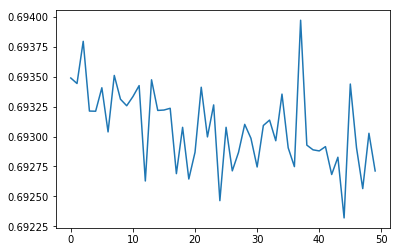

In [0]:
import time
import torch.optim as optim

learning_rate = 0.001
rnn=LSTM(n_letters, n_hidden, 2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(rnn.parameters(), lr = learning_rate, momentum = 0.9)

n_iters = 10000
batch_size = 12
use_first_characters = 100
print_every = 100
plot_every = 200

# keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = s//60
    s -= m*60
    return "{}m {}s".format(m, s)
  
def mathsPhysicsFromOutput(out):
    top_n, top_i = out.topk(1)
    category_i = top_i[0].item()
    cats = ["Mathematics", "Physics"]
    return cats[category_i], category_i

def randomMathsPhysics(use_first_n_characters):
    cats = ["Mathematics", "Physics"]
    category = choice(cats)
    category_tensor = torch.tensor([cats.index(category)], dtype=torch.long)
    article = choice(articles_dict[category])
    abstract = article["abstract"][:use_first_n_characters]
    abstract_tensor = lineToTensor(abstract)
    return category, abstract, category_tensor, abstract_tensor

start = time.time()

for it in range(1, n_iters+1):
  
    optimizer.zero_grad()
    
    training_batch = torch.zeros(use_first_characters, batch_size, n_letters)
    category_batch = torch.zeros(batch_size, dtype=torch.long)
    batch = 0
    while batch < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomMathsPhysics(use_first_characters)
        if len(abstract) < use_first_characters:
            # do this nasty "trick" to guarantee all the tensors have the same size
            continue
        
        training_batch[:, batch, :] = abstract_tensor[:, 0, :]
        category_batch[batch] = category_tensor[:]
        batch += 1
        
    output = rnn(training_batch)

    loss = criterion(output, category_batch)
    loss.backward()

    current_loss += loss.item()
    optimizer.step()
      
    
    if not (it % print_every):
        guess, guess_i = mathsPhysicsFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

0


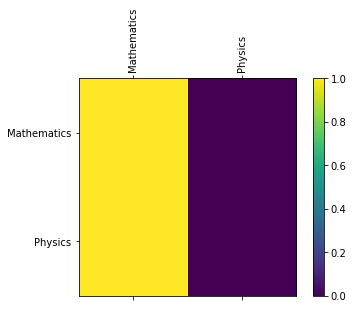

In [0]:
confusion = torch.zeros(2,2)
n_confusion = 10000
cats = ["Mathematics", "Physics"]

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    if 0 == i%n_confusion:
        print(i)
    category, line, category_tensor, line_tensor = randomMathsPhysics(use_first_characters)
    output = rnn(line_tensor)
    guess, guess_i = mathsPhysicsFromOutput(output)
    category_i = cats.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(2):
    confusion[i] = confusion[i] / confusion[i].sum()

import matplotlib.ticker as ticker
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + cats, rotation=90)
ax.set_yticklabels([''] + cats)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

## Experiment Maths VS Physics, take 3

 - increase number of characters used
 - increase number of iterations
 - increase learning rate SLIGHTLY (factor of $5$)

100 0.25% (0.0m 11.183091878890991s) 0.7182 / Mathematics X Physics
200 0.5% (0.0m 22.291297674179077s) 0.6918 / Mathematics X Physics
300 0.75% (0.0m 33.339027881622314s) 0.6916 / Mathematics V
400 1.0% (0.0m 44.492998361587524s) 0.6916 / Mathematics X Physics
500 1.25% (0.0m 55.68838024139404s) 0.692 / Physics V
600 1.5% (1.0m 7.264852046966553s) 0.6901 / Mathematics X Physics
700 1.75% (1.0m 18.331895351409912s) 0.6923 / Physics V
800 2.0% (1.0m 29.333234548568726s) 0.6973 / Physics V
900 2.25% (1.0m 40.40737271308899s) 0.7049 / Physics X Mathematics
1000 2.5% (1.0m 51.53058838844299s) 0.702 / Physics X Mathematics
1100 2.75% (2.0m 2.673916816711426s) 0.6995 / Physics V
1200 3.0% (2.0m 13.584998846054077s) 0.6911 / Mathematics V
1300 3.25% (2.0m 24.705442667007446s) 0.6947 / Physics V
1400 3.5% (2.0m 35.81112766265869s) 0.695 / Physics X Mathematics
1500 3.75% (2.0m 46.879634380340576s) 0.6969 / Physics X Mathematics
1600 4.0% (2.0m 57.970335245132446s) 0.7358 / Physics V
1700 4.25%

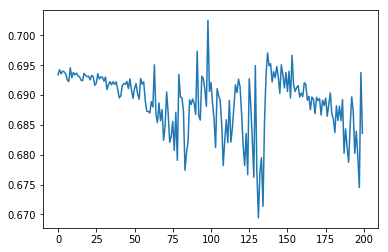

In [0]:
import time
import torch.optim as optim

learning_rate = 0.005
rnn=LSTM(n_letters, n_hidden, 2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(rnn.parameters(), lr = learning_rate, momentum = 0.9)

n_iters = 40000
batch_size = 12
use_first_characters = 150
print_every = 100
plot_every = 200

# keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = s//60
    s -= m*60
    return "{}m {}s".format(m, s)
  
def mathsPhysicsFromOutput(out):
    top_n, top_i = out.topk(1)
    category_i = top_i[0].item()
    cats = ["Mathematics", "Physics"]
    return cats[category_i], category_i

def randomMathsPhysics(use_first_n_characters):
    cats = ["Mathematics", "Physics"]
    category = choice(cats)
    category_tensor = torch.tensor([cats.index(category)], dtype=torch.long)
    article = choice(articles_dict[category])
    abstract = article["abstract"][:use_first_n_characters]
    abstract_tensor = lineToTensor(abstract)
    return category, abstract, category_tensor, abstract_tensor

start = time.time()

for it in range(1, n_iters+1):
  
    optimizer.zero_grad()
    
    training_batch = torch.zeros(use_first_characters, batch_size, n_letters)
    category_batch = torch.zeros(batch_size, dtype=torch.long)
    batch = 0
    while batch < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomMathsPhysics(use_first_characters)
        if len(abstract) < use_first_characters:
            # do this nasty "trick" to guarantee all the tensors have the same size
            continue
        
        training_batch[:, batch, :] = abstract_tensor[:, 0, :]
        category_batch[batch] = category_tensor[:]
        batch += 1
        
    output = rnn(training_batch)

    loss = criterion(output, category_batch)
    loss.backward()

    current_loss += loss.item()
    optimizer.step()
      
    
    if not (it % print_every):
        guess, guess_i = mathsPhysicsFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


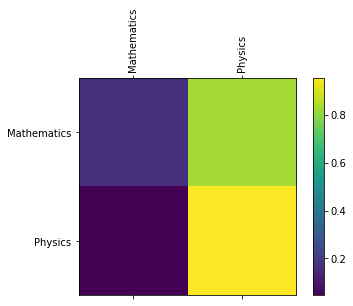

In [0]:
confusion = torch.zeros(2,2)
n_confusion = 10000
cats = ["Mathematics", "Physics"]

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    if 0 == i%(n_confusion//10):
        print(i)
    category, line, category_tensor, line_tensor = randomMathsPhysics(use_first_characters)
    output = rnn(line_tensor)
    guess, guess_i = mathsPhysicsFromOutput(output)
    category_i = cats.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(2):
    confusion[i] = confusion[i] / confusion[i].sum()

import matplotlib.ticker as ticker
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + cats, rotation=90)
ax.set_yticklabels([''] + cats)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()